[View in Colaboratory](https://colab.research.google.com/github/gresash/ML4AAD-Lab-SS2018/blob/master/Exercise2/Exercise_2_2.ipynb)

# Hyperparameter Optimization of SVM with Instances
* Installation of SMAC and its Dependencies
* Without instances: Optimization of Hyperparameters of SVM on Iris Dataset
* With instances: Optimization of Hyperparameters of SVM on Iris Dataset

## Installation of SMAC and its Dependencies

In [19]:
!apt-get install swig -y
!pip install Cython
!pip install pyrfr==0.8.0 --no-cache --user
# hack to find pyrfr
import sys
sys.path.insert(0,"./.local/lib/python3.6/site-packages")

!pip install git+https://github.com/automl/SMAC3.git@development
import logging
logging.basicConfig(level=logging.INFO)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.10-1.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Cloning https://github.com/automl/SMAC3.git (to revision development) to /tmp/pip-req-build-8ydyzug0
  Running setup.py bdist_wheel for smac ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-5someyrl/wheels/f4/8d/4f/2ba4cb80693f139ea06c2e8541e012a93738fb56bc1e43a202
Successfully built smac


## Define Useful Functions for plotting and getting data from SMAC runs

In [0]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt


def get_history(smac):
    # get runhistory, all runs ever evaluated by smac
    runhistory = smac.get_runhistory()

    # extract x value and corresponding y value
    cost = []
    for entry in runhistory.data:  # iterate over data because it is an OrderedDict
        config_id = entry.config_id  # look up config id
        config = runhistory.ids_config[config_id]  # look up config
        z_ = runhistory.get_cost(config)  # get cost
        cost.append(z_)
    cost = np.array(cost)
    return cost


def plot_log_scale(y_smac, maxfun, label, color):
    x = np.linspace(0, maxfun, num=maxfun)
    # Plotting
    ax = plt.subplot(111)

    plt.xlabel('#evaluations')
    plt.ylabel('Loss')

    # let's plot only the best function value at each time step
    y_min = np.zeros(maxfun)
    y_median = np.zeros(maxfun)
    y_25th = np.zeros(maxfun)
    y_75th = np.zeros(maxfun)
    for id in range(maxfun):
        y_min[id] = np.min(y_smac[:id+1])
        y_median[id] = np.percentile(y_min[:id+1], 50)
        y_25th[id] = np.percentile(y_min[:id+1], 25)
        y_75th[id] = np.percentile(y_min[:id+1], 75)

    plt.plot(y_median, 'o', color=color)
    ax.step(y_median, 'k', where="post", label=label, color=color)
    ax.set_xscale("log")
    plt.fill_between(x, y_25th, y_75th, alpha=0.5, color=color, step='pre')
    plt.show()

iris = load_iris()


def create_instance_string(X, y, X_test, y_test):
    feature1_str = ""
    for i in X[:, 0]:
        feature1_str += (str(i) + "\n")
    for i in X[:, 1]:
        feature1_str += (str(i) + "\n")
    for i in X[:, 2]:
        feature1_str += (str(i) + "\n")
    for i in X[:, 3]:
        feature1_str += (str(i) + "\n")
    for i in y:
        feature1_str += (str(i) + "\n")
    for i in X_test[:, 0]:
        feature1_str += (str(i) + "\n")
    for i in X_test[:, 1]:
        feature1_str += (str(i) + "\n")
    for i in X_test[:, 2]:
        feature1_str += (str(i) + "\n")
    for i in X_test[:, 3]:
        feature1_str += (str(i) + "\n")
    for i in y_test:
        feature1_str += (str(i) + "\n")
    return feature1_str


def read_instance_from_string(instance):
    feature1 = []
    feature2 = []
    feature3 = []
    feature4 = []
    labels = []
    feature1_test = []
    feature2_test = []
    feature3_test = []
    feature4_test = []
    labels_test = []
    instance = instance.split("\n")
    instance = instance[:-1]
    for i in instance[:120]:
        feature1.append(float(i))
    for i in instance[120:240]:
        feature2.append(float(i))
    for i in instance[240:360]:
        feature3.append(float(i))
    for i in instance[360:480]:
        feature4.append(float(i))
    for i in instance[480:600]:
        labels.append(int(i))
    for i in instance[600:630]:
        feature1_test.append(float(i))
    for i in instance[630:660]:
        feature2_test.append(float(i))
    for i in instance[660:690]:
        feature3_test.append(float(i))
    for i in instance[690:720]:
        feature4_test.append(float(i))
    for i in instance[720:]:
        labels_test.append(int(i))
    return np.array([feature1, feature2, feature3, feature4]).T, labels, np.array([feature1_test, feature2_test, feature3_test, feature4_test]).T, labels_test


## Define Functions to be optimized (SVM with Iris Dataset)

In [0]:
def svc_from_cfg_no_instances(cfg):
    """ Creates a SVM based on a configuration and evaluates it on the
    iris-dataset using cross-validation.

    Parameters:
    -----------
    cfg: Configuration (ConfigSpace.ConfigurationSpace.Configuration)
        Configuration containing the parameters.
    Returns:
    --------
    A crossvalidated mean score for the svm on the loaded data-set.
    """
    # For deactivated parameters, the configuration stores None-values.
    # This is not accepted by the SVM, so we remove them.
    cfg = {k: cfg[k] for k in cfg if cfg[k]}
    # We translate boolean values
    cfg["shrinking"] = True if cfg["shrinking"] == "true" else False
    # And for gamma, we set it to a fixed value or to "auto" (if used)
    if "gamma" in cfg:
        cfg["gamma"] = cfg["gamma_value"] if cfg["gamma"] == "value" else "auto"
        cfg.pop("gamma_value", None)  # Remove "gamma_value"
    clf = SVC(**cfg, random_state=42)
    scores = cross_val_score(clf, iris.data, iris.target, cv=5, scoring=make_scorer(accuracy_score))
    return np.mean(scores)


def svc_from_cfg(cfg, instance, seed=0):
    """ Creates a SVM based on a configuration and evaluates it on the
    iris-dataset using cross-validation.

    Parameters:
    -----------
    cfg: Configuration (ConfigSpace.ConfigurationSpace.Configuration)
        Configuration containing the parameters.
    Returns:
    --------
    A crossvalidated mean score for the svm on the loaded data-set.
    """
    # For deactivated parameters, the configuration stores None-values.
    # This is not accepted by the SVM, so we remove them.
    try:
        data, labels, data_test, labels_test = read_instance_from_string(instance)
        cfg = {k: cfg[k] for k in cfg if cfg[k]}
        # We translate boolean values
        cfg["shrinking"] = True if cfg["shrinking"] == "true" else False
        # And for gamma, we set it to a fixed value or to "auto" (if used)
        if "gamma" in cfg:
            cfg["gamma"] = cfg["gamma_value"] if cfg["gamma"] == "value" else "auto"
            cfg.pop("gamma_value", None)  # Remove "gamma_value"
        clf = SVC(**cfg, random_state=42)
        clf.fit(data, labels)
        predicted = clf.predict(data_test)
        score = accuracy_score(labels_test, predicted)
    except TypeError:
        pass
    return score


# Define Instance Space
Let's simply assume that we discretize the y-axis into 20 instances

In [0]:
kf = KFold(n_splits=5)
indexes_train=[]
indexes_test=[]
X1 = []
X2 = []
X3 = []
X4 = []
X5 = []

y1 = []
y2 = []
y3 = []
y4 = []
y5 = []

X1_test = []
X2_test = []
X3_test = []
X4_test = []
X5_test = []

y1_test = []
y2_test = []
y3_test = []
y4_test = []
y5_test = []

for i1, i2 in kf.split(iris.data):
    indexes_train.append(i1)
    indexes_test.append(i2)

X1 = iris.data[indexes_train[0]]
X2 = iris.data[indexes_train[1]]
X3 = iris.data[indexes_train[2]]
X4 = iris.data[indexes_train[3]]
X5 = iris.data[indexes_train[4]]


y1 = iris.target[indexes_train[0]]
y2 = iris.target[indexes_train[1]]
y3 = iris.target[indexes_train[2]]
y4 = iris.target[indexes_train[3]]
y5 = iris.target[indexes_train[4]]

X1_test = iris.data[indexes_test[0]]
X2_test = iris.data[indexes_test[1]]
X3_test = iris.data[indexes_test[2]]
X4_test = iris.data[indexes_test[3]]
X5_test = iris.data[indexes_test[4]]


y1_test = iris.target[indexes_test[0]]
y2_test = iris.target[indexes_test[1]]
y3_test = iris.target[indexes_test[2]]
y4_test = iris.target[indexes_test[3]]
y5_test = iris.target[indexes_test[4]]


#Creating instances for SMAC to optimize on
instance1 = create_instance_string(X1, y1, X1_test, y1_test)
instance2 = create_instance_string(X2, y2, X2_test, y2_test)
instance3 = create_instance_string(X3, y3, X3_test, y3_test)
instance4 = create_instance_string(X4, y4, X4_test, y4_test)
instance5 = create_instance_string(X5, y5, X5_test, y5_test)


## Define Configuration Space

In [23]:
from smac.configspace import ConfigurationSpace
from ConfigSpace.conditions import InCondition
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter

cs = ConfigurationSpace()

shrinking = CategoricalHyperparameter("shrinking", ["true", "false"], default_value="true")
kernel = CategoricalHyperparameter("kernel", ["linear", "poly", "rbf", "sigmoid"], default_value="poly")
degree = UniformIntegerHyperparameter("degree", 1, 5, default_value=3)
gamma = CategoricalHyperparameter("gamma", ["auto", "value"], default_value="value")
gamma_value = UniformFloatHyperparameter("gamma_value", 0.001, 8, default_value=1)
coef0 = UniformFloatHyperparameter("coef0", 0.0, 10.0, default_value=0.0)
c = UniformFloatHyperparameter("C", 0.001, 1000.0, default_value=1.0)

cs.add_hyperparameters([c, kernel, degree, shrinking, gamma, gamma_value, coef0])
use_degree = InCondition(child=degree, parent=kernel, values=["poly"])
use_gamma_value = InCondition(child=gamma_value, parent=gamma, values=["value"])
use_gamma = InCondition(child=gamma, parent=kernel, values=["poly", "rbf", "sigmoid"])
use_coef0 = InCondition(child=coef0, parent=kernel, values=["poly", "sigmoid"])
cs.add_conditions([use_degree, use_gamma_value, use_gamma, use_coef0])


[degree | kernel in {'poly'},
 gamma_value | gamma in {'value'},
 gamma | kernel in {'poly', 'rbf', 'sigmoid'},
 coef0 | kernel in {'poly', 'sigmoid'}]

##Without instances: Run SMAC on SVM with Iris Dataset

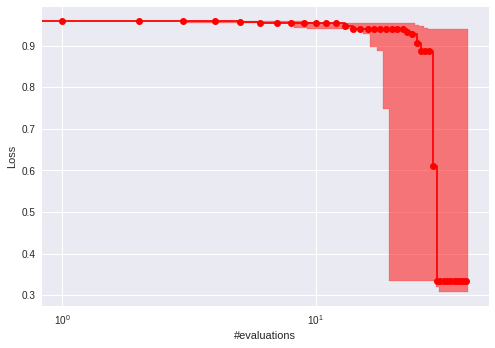

In [27]:
from smac.scenario.scenario import Scenario
from smac.facade.smac_facade import SMAC

scenario = Scenario({"run_obj": "quality",  # we optimize quality (alternative runtime)
                    "runcount-limit": 40,  # time for running SMAC
                     "cs": cs,  # configuration space
                     "deterministic": "true",
                     })

for i in np.random.randint(10000, size=1):
    smac = SMAC(scenario=scenario, rng=np.random.RandomState(i),
                tae_runner=svc_from_cfg_no_instances)

    incumbent = smac.optimize()
    cost = get_history(smac)
    plot_log_scale(cost, 40, "SVM", "red")


## With instances: Run SMAC on SVM with Iris Dataset

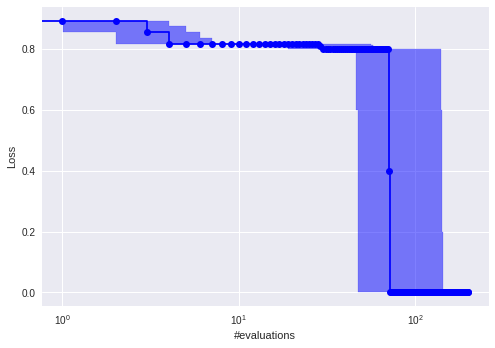

In [28]:
# Build a scenario
scenario = Scenario({"run_obj": "quality",  # we optimize quality
                     "runcount-limit": 200,  # maximum number of function evaluations
                     "cs": cs,               # configuration space
                     "deterministic": "true",
                     "instances": [[instance1], [instance2], [instance3], [instance4], [instance5]]
                     })
# start SMAC
smac = SMAC(scenario=scenario,
            rng=np.random.RandomState(1234),
            tae_runner=svc_from_cfg)

best_x = smac.optimize()
cost = get_history(smac)
plot_log_scale(cost, 200, "SVM", "blue")
